## Suppl. Fig3 panel B

This notebooks:
- Loads preprocessed enrichment table
- Computes correlation between each pair of proteins using their enrichment profiles 
- Loads the (external) OpenCell protein-protein interaction data, and extract protein-protein interaction stoichiometry
- Loads the (external) Corum 3.0 data
- Plots a binned heatmap of enrichment correlation vs. protein-protein interaction stoichiometry. Plots variants of 

- result files are written to a folder named ``output``


In [1]:
import sys
import numpy as np
import pandas as pd
import anndata as ad
import os
import copy
from collections import defaultdict
import seaborn as sns; sns.set_theme(color_codes=True)
from tqdm.notebook import trange, tqdm
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import bokeh.palettes
import plotly.io as pio
import itertools
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
from pathlib import Path

plt.rcParams['pdf.fonttype'] = 42
script_path = Path.cwd().parent.parent.parent.parent / "script"
data_path = Path.cwd().parent.parent.parent.parent / "data"
sys.path.append(str(script_path))
from pyseus.plotting import plotly_umap as pu
from external import clustering_workflows

save_path = Path.cwd() / "output"
if not os.path.exists(save_path):
    os.makedirs(save_path)

## Data Prep work

### Load the preprocessed enrichment table (saved in the umap_table)

In [2]:
# timestamp = datetime.now().strftime('%Y-%m-%d')
# print(f"Timestamp: {timestamp}")    

In [3]:
#manually set the timestamp to use the intermediate results from another date
timestamp = "2023-10-21-imp5"

In [4]:
# define files to load
input_dir = Path.cwd().parent.parent.parent / "Fig2" / "panel_C" / "output"
umap_table_path = input_dir / f"{timestamp}_umap_table.csv"
quants_path = input_dir / f"{timestamp}_quants.csv"

# load data
try:
    # load the file
    umap_table = pd.read_csv(umap_table_path, index_col=0)
except FileNotFoundError:
    print(f"File {umap_table_path} not found.\nPlease run Fig2_C_consensus_annotation.ipynb first or specify the correct timestamp, current value is {timestamp}")
except pd.errors.ParserError:
    print(f"There was an error parsing the CSV file at {umap_table_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

try:
    # load the file
    quants = pd.read_csv(quants_path, index_col=0)
except FileNotFoundError:
    print(f"File {quants_path} not found.\nPlease run Fig2_C_consensus_annotation.ipynb first or specify the correct timestamp, current value is {timestamp}")
except pd.errors.ParserError:
    print(f"There was an error parsing the CSV file at {quants_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [5]:
print(f"the dimensions of the (umap) data table loaded are {quants.shape}")
# scale the data
scaled = pu.scale_table(matrix=quants, method='standard')

the dimensions of the (umap) data table loaded are (8541, 61)


In [6]:
umap_genes = umap_table["Gene_name_canonical"].to_list()

### Load the OpenCell protein-protein interaction data and dedup

In [7]:
stoi_df = pd.read_csv(data_path / "external" / "opencell-protein-interactions.csv")
print(f"the dimensions of the protein-protein interaction data table loaded are {stoi_df.shape}")

the dimensions of the protein-protein interaction data table loaded are (29922, 9)


In [8]:
# # check the distro of interaction_stoichiometry in log scale
# fig, ax = plt.subplots(figsize=(10, 2))
# sns.histplot(np.log10(stoi_df['interaction_stoichiometry']), bins=100, kde=True)
# ax.set_xlabel("log10(interaction_stoichiometry)")

In [9]:
# drop rows with NaNs and zeros in the stoi column
stoi_df = stoi_df.dropna(subset=['interaction_stoichiometry'])
stoi_df = stoi_df[stoi_df['interaction_stoichiometry'] != 0]


In [10]:
# check if there are any duplicated pairs
pairs_dict = defaultdict(int)
stoi_genes = set()
for index, row in stoi_df.iterrows():
    pairs_dict[frozenset([row['target_gene_name'], row['interactor_gene_name']])] += 1
    stoi_genes.add(row['target_gene_name'])
    stoi_genes.add(row['interactor_gene_name'])
dup_pairs = [x for x in pairs_dict.keys() if pairs_dict[x] > 1]
print(f"number of duplicated pairs: {len(dup_pairs)}")
print(f"number of unique genes in the STOI table: {len(stoi_genes)}")

number of duplicated pairs: 1312
number of unique genes in the STOI table: 5187


In [11]:
pairs_stoi = defaultdict(float)
for index, row in stoi_df.iterrows():
    t = row['target_gene_name']
    i = row['interactor_gene_name']
    if frozenset([t, i]) not in dup_pairs:
        pairs_stoi[frozenset([t, i])] = row['interaction_stoichiometry']
    else:
        pairs_stoi[frozenset([t, i])] = max(row['interaction_stoichiometry'], pairs_stoi[frozenset([t, i])])

In [12]:
print(f"total number of protein pairs in the OpenCell stoichiometry table is {len(pairs_stoi)}")

total number of protein pairs in the OpenCell stoichiometry table is 27877


### Load corum data

In [13]:
corum = pd.read_csv(data_path / "external" / "Corum.3.0.csv")

In [14]:
# extract pairwise complex membership information from corum data
pairs_corum = defaultdict(float)

for compl in corum['desc'].unique():
    genes = corum[corum['desc'] == compl]['varname'].to_list()
    #print(f"complex {compl} has {len(genes)} genes")
    for pair in itertools.combinations(genes, 2):
        pairs_corum[frozenset(pair)] = 1

In [15]:
print(f"total number of protein pairs in the Corum table is {len(pairs_corum)}")

total number of protein pairs in the Corum table is 225627


## plot *IP correlation* vs stoichiometry

In [16]:
# compute IP correlation
metric = "pearson" # define the correlation metric to use

scaled_df = pd.DataFrame(scaled.T)
corr_mat = scaled_df.corr(method=metric)
corr_mat = np.array(corr_mat)

# check the dimension of the correlation matrix (both dims should equal to the number of genes)
corr_mat.shape

(8541, 8541)

In [17]:
# extract pairwise correlation information from the correlation matrix
corr_pairs = defaultdict(float)

for i in tqdm(range(corr_mat.shape[0])):
    for j in range(i+1, corr_mat.shape[1]):
        corr_pairs[frozenset([umap_genes[i], umap_genes[j]])] = corr_mat[i, j]

  0%|          | 0/8541 [00:00<?, ?it/s]

In [18]:
# reduce the pairs to those that are in both the correlation and stoichiometry dataset

pair_count = 0
corr = []
stoi = []

for pair in corr_pairs.keys():
    if pair in pairs_stoi.keys():
        pair_count += 1
        corr.append(corr_pairs[pair])
        stoi.append(pairs_stoi[pair])

print(f"number of pairs in both correlatoin table and OpenCell stoichiometry table is {pair_count}")


number of pairs in both correlatoin table and OpenCell stoichiometry table is 23264


In [19]:
# separatly 
pair_count = 0
corr_corrum = []
stoi_corrum = []

for pair in corr_pairs.keys():
    if pair in pairs_stoi.keys():
        if pair in pairs_corum.keys():
            pair_count += 1
            corr_corrum.append(corr_pairs[pair])
            stoi_corrum.append(pairs_stoi[pair])

print(f"number of pairs in both correlatoin table and OpenCell stoichiometry table, AND are in a corum complex is {pair_count}")


number of pairs in both correlatoin table and OpenCell stoichiometry table, AND are in a corum complex is 3500


### plots

C:\Users\duo.peng\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:1210: UserWarning:

The following kwargs were not used by contour: 'linewidth'



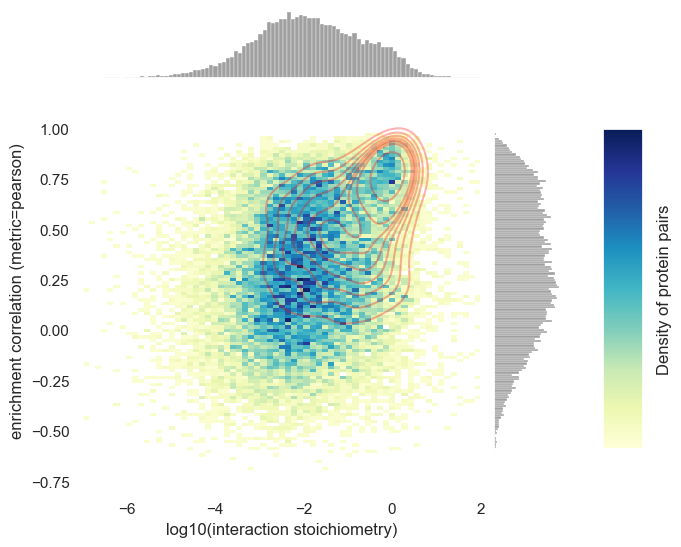

meta NOT subset; don't know how to subset; dropped


In [23]:
# with Corum overlay

g = sns.jointplot(y=corr, x=np.log10(stoi), kind="hist", bins=100, cmap="YlGnBu", 
                    height=8, marginal_kws=dict(bins=150, fill=True, color="grey"))
sns.kdeplot(y=corr_corrum, x=np.log10(stoi_corrum),color= "red", linewidth = 0.1, alpha=0.3,
            thresh = 0.2, levels = 9, ax=g.ax_joint)
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
cbar_ax = g.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
plt.colorbar(g.ax_joint.collections[0], cax=cbar_ax, label="Density of protein pairs", ticks=[])
g.ax_joint.set_xlim(-7, 2)
#g.ax_joint.set_ylim(0, 2)
g.ax_joint.set_ylabel(f"enrichment correlation (metric={metric})")
g.ax_joint.set_xlabel("log10(interaction stoichiometry)")
#set white bg
g.ax_joint.set_facecolor('white')
g.ax_marg_y.set_facecolor('white')
g.ax_marg_x.set_facecolor('white')
plt.show()
g.savefig(save_path / f"enrichment_[{metric}]_corr_vs_stoi_w_CORUM_contour.pdf", dpi=300, bbox_inches='tight')


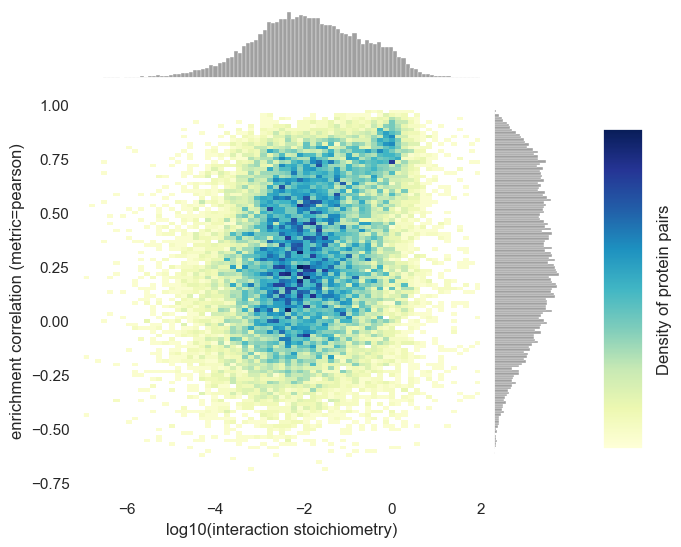

meta NOT subset; don't know how to subset; dropped


In [24]:
# without Corum overlay

g = sns.jointplot(y=corr, x=np.log10(stoi), kind="hist", bins=100, cmap="YlGnBu", 
                    height=8, marginal_kws=dict(bins=150, fill=True, color="grey"))
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
cbar_ax = g.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
plt.colorbar(g.ax_joint.collections[0], cax=cbar_ax, label="Density of protein pairs", ticks=[])
g.ax_joint.set_xlim(-7, 2)
#g.ax_joint.set_ylim(0, 2)
g.ax_joint.set_ylabel(f"enrichment correlation (metric={metric})")
g.ax_joint.set_xlabel("log10(interaction stoichiometry)")
#set white bg
g.ax_joint.set_facecolor('white')
g.ax_marg_y.set_facecolor('white')
g.ax_marg_x.set_facecolor('white')
plt.show()
g.savefig(save_path / f"enrichment_[{metric}]_corr_vs_stoi.pdf", dpi=300, bbox_inches='tight')


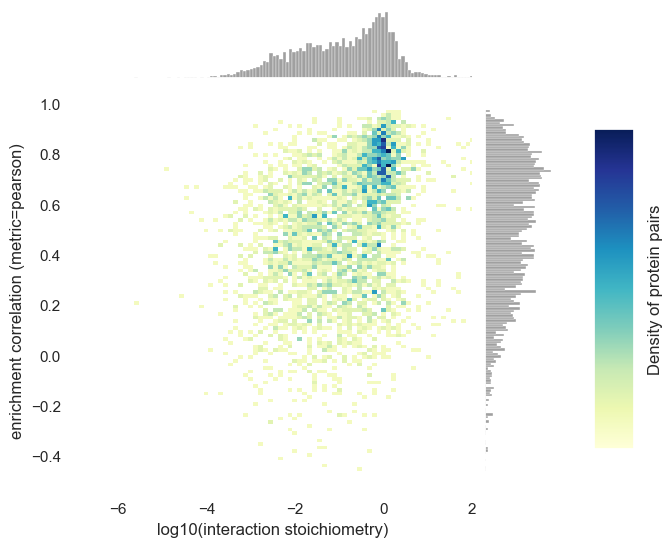

meta NOT subset; don't know how to subset; dropped


In [25]:
# only show protein pairs in the Corum complex (data underlying the contours above)
g = sns.jointplot(y=corr_corrum, x=np.log10(stoi_corrum), kind="hist", bins=100, cmap="YlGnBu", 
                    height=8, marginal_kws=dict(bins=150, fill=True, color="grey"))
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
cbar_ax = g.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
plt.colorbar(g.ax_joint.collections[0], cax=cbar_ax, label="Density of protein pairs", ticks=[])
g.ax_joint.set_xlim(-7, 2)
#g.ax_joint.set_ylim(0, 2)
g.ax_joint.set_ylabel(f"enrichment correlation (metric={metric})")
g.ax_joint.set_xlabel("log10(interaction stoichiometry)")
#set white bg
g.ax_joint.set_facecolor('white')
g.ax_marg_y.set_facecolor('white')
g.ax_marg_x.set_facecolor('white')
plt.show()
g.savefig(save_path / f"enrichment_[{metric}]_corr_vs_stoi_Corum_complex_only.pdf", dpi=300, bbox_inches='tight')
